# Fashion-MNIST classifiers without deep learning libraries

## Import necessary libraries and process data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
eps = np.finfo(float).eps

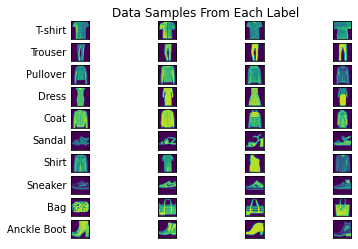

In [2]:
class DataProcessing:
    
    def visualize_data():
        labels = {0: 'T-shirt', 
                  1: 'Trouser', 
                  2: 'Pullover', 
                  3: 'Dress',
                  4: 'Coat', 
                  5: 'Sandal', 
                  6: 'Shirt', 
                  7: 'Sneaker', 
                  8: 'Bag', 
                  9: 'Anckle Boot'}
        
        train = np.loadtxt('train.csv', delimiter= ',', skiprows = 1)
        fig, axs = plt.subplots(nrows = 10, ncols = 4)
        for label in range(len(labels)):
            CheckLabel = (train[:,0] == label)
            image_index = np.where(CheckLabel == True)[0]
            for picture_index in range(4):
                image = train[image_index[picture_index], 1:].reshape(28, 28)
                axs[label, picture_index].imshow(image)
                axs[label, picture_index].xaxis.set_ticks([])
                axs[label, picture_index].yaxis.set_ticks([])
            
            axs[label, 0].set_ylabel(labels[label], rotation = 'horizontal',
                                     verticalalignment = 'center',
                                     horizontalalignment = 'right')
        fig.suptitle('Data Samples From Each Label', y = 0.93)
        plt.show()
        
        
    def min_max_normalization(x, x_train):
        x_min = np.min(x_train, axis = 0)
        x_max = np.max(x_train, axis = 0)
        return (x - x_min) / (x_max - x_min + eps)
    
    
    def pre_process_data(val_percentage):
        train = np.loadtxt('train.csv', delimiter = ',', skiprows = 1)
        test = np.loadtxt('test.csv', delimiter =',', skiprows = 1)
    
        # split train data to train and validation sets randomly:
        chosen_test = np.random.choice(train.shape[0], int(train.shape[0] * (1 - val_percentage)), replace=False)
        x_train = train[chosen_test, 1:]
        y_train = train[chosen_test, 0]
        x_val = np.delete(train, chosen_test, axis = 0)[:, 1:]
        y_val = np.delete(train, chosen_test, axis = 0)[:, 0]
        y_train_one_hot = np.zeros((y_train.size, int(np.max(y_train)) + 1))
        y_val_one_hot = np.zeros((y_val.size, int(np.max(y_val)) + 1))
       
        for i in range (y_train.size):
            y_train_one_hot[i] = np.concatenate((np.zeros(int(y_train[i])), np.ones(1), np.zeros(int(np.max(y_train) - y_train[i]))))
        
        for j in range (y_val.size):
            y_val_one_hot[j] = np.concatenate((np.zeros(int(y_val[j])), np.ones(1), np.zeros(int(np.max(y_val) - y_val[j]))))
    
        # test data:
        x_test = test
        
       # normalized data:
        x_val = DataProcessing.min_max_normalization(x_val, x_train).T
        x_test = DataProcessing.min_max_normalization(x_test, x_train).T
        x_train = DataProcessing.min_max_normalization(x_train, x_train).T
    
        y_train_one_hot = y_train_one_hot.T
        y_val_one_hot = y_val_one_hot.T
        
        # increase dimension of input by 1 for bias term:
        x_train_bias = np.vstack((x_train, np.ones(x_train.shape[1]).reshape(1, x_train.shape[1])))
        x_val_bias = np.vstack((x_val, np.ones(x_val.shape[1]).reshape(1, x_val.shape[1])))
        x_test_bias = np.vstack((x_test, np.ones(x_test.shape[1]).reshape(1, x_test.shape[1])))
        
        return x_train_bias, y_train_one_hot, x_val_bias, y_val_one_hot, x_test_bias

DataProcessing.visualize_data()
        

## Logistic Regression Classifier

In [53]:
class LogisticRegression:
    def __init__(self, batch_size, learning_rate, epochs, reg_factor, val_per):
        self.bs = batch_size
        self.lr = learning_rate
        self.epochs = epochs
        self.rf = reg_factor
        self.val_per = val_per
        self.train_losses, self.train_accuracies, self.val_losses, self.val_accuracies  = ([] for _ in range(4))
        
        
    def train(self):
        x_train_bias, y_train_one_hot, x_val_bias, y_val_one_hot, x_test_bias = DataProcessing.pre_process_data(self.val_per)
        train_samples = x_train_bias.shape[1] 
        train_features = x_train_bias.shape[0] 
        w = np.random.normal(loc = 0, scale = 0.01, size = (10, train_features))
        # how many chunks the training data is divided to:
        num_of_batches = int(np.ceil(train_samples / self.bs))

        for epoch in range(self.epochs):
            batch_loss = 0
            batch_accuracy = 0
            for chunk in range(num_of_batches): 
                x_batch = x_train_bias[:, chunk * self.bs:(chunk + 1) * self.bs]
                y_one_hot_batch = y_train_one_hot[:, chunk * self.bs:(chunk + 1) * self.bs]
                z = w @ x_batch
                SoftMax = self.softmax(z) # P(y_t = i|x_t) for each sample in the batch
                batch_loss += self.cross_entropy(SoftMax, y_one_hot_batch) + self.rf * np.sum(np.power(w, 2))
                preds = np.argmax(SoftMax, axis = 0)
                batch_accuracy += np.mean(np.equal(preds, np.argmax(y_one_hot_batch, axis = 0)))
               
                # compute gradients of loss function by w:
                gradient = self.dLdW(x_batch, y_one_hot_batch, SoftMax) + 2 * self.rf * w
               
                # update weights:
                w -= self.lr * gradient
           
            y_true = np.argmax(y_train_one_hot, axis = 0)
            y_pred = np.argmax(w @ x_train_bias, axis = 0)
            train_accuracy = np.mean(np.equal(y_true, y_pred))
            train_loss = self.cross_entropy(self.softmax( w @ x_train_bias), y_train_one_hot) + self.rf * np.sum(np.power(w, 2)) 
            self.train_accuracies.append(train_accuracy)
            self.train_losses.append(train_loss)
            print('Epoch: ' + str(epoch + 1) +', ' + 'Train Accuracy: ' + str(train_accuracy) + ', ' + 'Train Loss: ' + str(train_loss) , end = "\r")
            
            # validation:
            val_loss, val_accuracy = self.validate(x_val_bias, y_val_one_hot, w) 
            self.val_accuracies.append(val_accuracy)
            self.val_losses.append(val_loss)
        return w, x_test_bias
    
    
    def validate(self,x_val_bias, y_val_one_hot, w):
        z_val = w @ x_val_bias
        softmax_val = self.softmax(z_val)
        preds_val = np.argmax(softmax_val, axis = 0)
        loss_val = self.cross_entropy(softmax_val, y_val_one_hot) + self.rf * np.sum(np.power(w, 2))
        accuracy_val = np.mean(np.equal(preds_val, np.argmax(y_val_one_hot, axis = 0)))
        return loss_val, accuracy_val
    
    
    def test(self, x_test, w):  
        z_test = w @ x_test
        softmax_test = self.softmax(z_test)
        preds_test = np.argmax(softmax_test, axis = 0)
        np.savetxt('lr_pred.csv', preds_test, fmt = '%i')
        return preds_test
    
     
    def plot(self):
        steps = np.arange(self.epochs)

        fig, ax1 = plt.subplots()
        fig.suptitle('Logistic Regression', y = 0.94, fontsize = 13)
        plt.title('Batch Size: ' + str(self.bs) + ', Learning Rate: ' + str(self.lr)
                  + ', Regularization Factor: ' + str(self.rf), fontsize = 10)

        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.plot(steps, self.train_losses, label = 'train loss', color = 'red')
        ax1.plot(steps, self.val_losses, label = 'validation loss', color = 'green')

        ax2 = ax1.twinx() 
        ax2.set_ylabel('acccuracy')
        ax2.plot(steps, self.train_accuracies, label = "train accuracy", color = 'blue')
        ax2.plot(steps, self.val_accuracies, label = "validation accuracy", color = 'black')
        
        fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.5))
        fig.tight_layout()
        plt.show()
        
        
    def softmax(self, z): # z is a matrix 10 X batch_size
        return np.exp(z - np.max(z,axis = 0)) / np.sum(np.exp(z - np.max(z,axis = 0)), axis = 0)
    
    
    def cross_entropy(self, SoftMax, y_one_hot_batch):
        n = y_one_hot_batch.shape[1]
        return - np.sum(np.log(SoftMax + eps) * y_one_hot_batch) / n 
    
    
    def dLdW(self, x_batch, y_one_hot_batch, SoftMax):
        n = y_one_hot_batch.shape[1]
        return - (y_one_hot_batch - SoftMax) @ x_batch.T / n

### Hyper-Parameters for Logistic Regression

In [56]:
#Hyper-Parameters:
n_epochs = 150
val_per = 0.2
batch_size = 256
lr = 0.01
reg_factor = 0.0001

### Training and testing the Logistic Regression classifier 

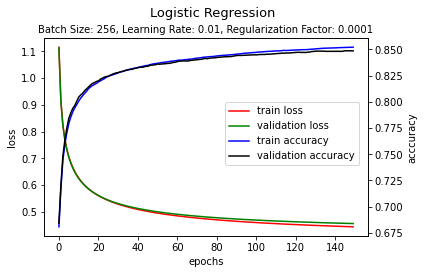

In [57]:
LR = LogisticRegression(batch_size, lr, n_epochs, reg_factor, val_per)
w, x_test_bias = LR.train()
LR.plot()
_ = LR.test(x_test_bias, w)

## Neural Network with One Hidden Layer

In [64]:
class NeuralNetwork:
    def __init__(self, batch_size, learning_rate, epochs, reg_factor, val_per, hidden_size, activation, drop_prob):
        self.bs = batch_size
        self.lr = learning_rate
        self.epochs = epochs
        self.rf = reg_factor
        self.val_per = val_per
        self.hidden_size = hidden_size
        self.activation = activation
        self.drop_prob = drop_prob
        self.train_losses, self.train_accuracies, self.val_losses, self.val_accuracies  = ([] for _ in range(4))
        
        
    def train(self):
        x_train_bias, y_train_one_hot, x_val_bias, y_val_one_hot, x_test_bias = DataProcessing.pre_process_data(self.val_per)
        train_samples = x_train_bias.shape[1]
        train_features = x_train_bias.shape[0]
        # increase dimension of w1 by 1 for b1 & dimension of w2 by 1 for b2:
        w1 = np.random.normal(loc = 0, scale = 0.01, size = (self.hidden_size, train_features))
        w2 = np.random.normal(loc = 0, scale = 0.01, size = (10, self.hidden_size + 1)) 

        # how many chunks the training data is divided to:
        num_of_batches = int(np.ceil(train_samples / self.bs))
    
        for epoch in range(self.epochs):
            batch_loss = 0
            batch_accuracy = 0
            for chunk in range(num_of_batches): 
                x_batch = x_train_bias[:, chunk * self.bs:(chunk + 1) * self.bs] 
                y_one_hot_batch = y_train_one_hot[:, chunk * self.bs:(chunk + 1) * self.bs] 
                # forward pass:
                z1 = w1 @ x_batch
                h = self.sigmoid(z1) if self.activation == 'sigmoid' else self.relu(z1)
                # dropout:
                h = self.dropout(h)
                # increase dimension of h by 1 for b2
                h = np.vstack((h, np.ones(h.shape[1]).reshape(1, h.shape[1])))
                z2 = w2 @ h
                SoftMax = self.softmax(z2)
                batch_loss += self.cross_entropy(SoftMax, y_one_hot_batch) + self.rf * (np.sum(np.power(w1, 2)) + np.sum(np.power(w2, 2)))
                preds = np.argmax(SoftMax, axis = 0)
                batch_accuracy += np.mean(np.equal(preds, np.argmax(y_one_hot_batch, axis = 0)))
                # compute gradients of loss function by w1 & w2:
                # backward pass:
                dLdZ2 = SoftMax - y_one_hot_batch
                dZ2dH = w2
                dHdZ1 = self.dSigmoiddZ1(z1) if self.activation == 'sigmoid' else self.dReludZ1(z1)
                dZ1dW1 = x_batch
                dLdW1 = ((dZ2dH.T @ dLdZ2)[:-1,:] * dHdZ1 @ dZ1dW1.T) / train_samples
                dZ2dW2 = h.T
                dLdW2 = (dLdZ2 @ dZ2dW2) / train_samples
            
                # update weights:
                w1 -= self.lr * (dLdW1 + 2 * self.rf * w1)
                w2 -= self.lr * (dLdW2 + 2 * self.rf * w2)
    
            y_true = np.argmax(y_train_one_hot, axis = 0)
            z1 = w1 @ x_train_bias
            h = self.sigmoid(z1) if self.activation == 'sigmoid' else self.relu(z1)
            # increase dimension by 1 for b2:
            h = np.vstack((h, np.ones(h.shape[1]).reshape(1, h.shape[1])))
            z2 = w2 @ h
            SoftMax = self.softmax(z2)
            y_pred = np.argmax(SoftMax, axis = 0)
            train_accuracy = np.mean(np.equal(y_true, y_pred))
            train_loss = self.cross_entropy(SoftMax, y_train_one_hot) + self.rf * (np.sum(np.power(w1, 2)) + np.sum(np.power(w2, 2)))
            self.train_accuracies.append(train_accuracy)
            self.train_losses.append(train_loss)
            print('Epoch: ' + str(epoch + 1) +', ' + 'Train Accuracy: ' + str(train_accuracy) + ', ' + 'Train Loss: ' + str(train_loss) , end = "\r")
        
            # validation:
            val_loss, val_accuracy = self.validate(x_val_bias, y_val_one_hot, w1, w2)
            self.val_accuracies.append(val_accuracy)
            self.val_losses.append(val_loss)
        return w1, w2, x_test_bias
 
        
    def validate(self, x_val_bias, y_val_one_hot,w1, w2): 
        z1 = w1 @ x_val_bias
        h = self.sigmoid(z1) if self.activation == 'sigmoid' else self.relu(z1)
        # increase dimension by 1 for b2:
        h = np.vstack((h, np.ones(h.shape[1]).reshape(1, h.shape[1])))
        z2 = w2 @ h
        softmax_val = self.softmax(z2)
        preds_val = np.argmax(softmax_val, axis = 0)
        loss_val = self.cross_entropy(softmax_val, y_val_one_hot) + self.rf * (np.sum(np.power(w1, 2)) + np.sum(np.power(w2, 2)))
        accuracy_val = np.mean(np.equal(preds_val, np.argmax(y_val_one_hot, axis = 0)))
        return loss_val, accuracy_val


    def test(self, x_test_bias, w1, w2):
        w1, w2 = (1 - self.drop_prob) * w1, (1 - self.drop_prob) * w2
        z1 = w1 @ x_test_bias
        h = self.sigmoid(z1) if self.activation == 'sigmoid' else self.relu(z1)
        # increase dimension by 1 for b2:
        h = np.vstack((h, np.ones(h.shape[1]).reshape(1, h.shape[1])))
        z2 = w2 @ h
        softmax_test = self.softmax(z2)
        preds_test = np.argmax(softmax_test, axis = 0)
        np.savetxt('NN_pred.csv', preds_test, fmt = '%i')
        return preds_test
    
    
    def plot(self):
        steps = np.arange(self.epochs)

        fig, ax1 = plt.subplots()
        fig.suptitle('Neural Network', y = 0.94, fontsize = 13)
        plt.title('Batch Size: ' + str(self.bs) 
                  + ', Learning Rate: ' + str(self.lr)
                  + ', Regularization Factor: ' + str(self.rf) 
                  + ', Hidden Size: ' + str(self.hidden_size) 
                  + ', Activation: ' + str(self.activation) 
                  + ', Drop Out Probability: ' + str(self.drop_prob), fontsize = 10)

        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.plot(steps, self.train_losses, label = "train loss", color = 'red')
        ax1.plot(steps, self.val_losses, label = "validation loss", color = 'green')

        ax2 = ax1.twinx() # second axes that shares the same x-axis as ax1
        ax2.set_ylabel('acccuracy')
        ax2.plot(steps, self.train_accuracies, label="train accuracy", color='blue')
        ax2.plot(steps, self.val_accuracies, label="validation accuracy", color='black')

        fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.5))
        fig.tight_layout()
        plt.show()


    def dropout(self, h):
        drop_idx = np.random.choice(h.shape[0], int(h.shape[0] * self.drop_prob), replace = False)
        mask = np.ones((h.shape[0], 1))
        mask[drop_idx, 0] = 0
        h = h * mask
        return h


    def dSigmoiddZ1(self, z1):
        return self.sigmoid(z1) * (1 - self.sigmoid(z1))
    
    
    def dReludZ1(self, z1):
        gradient = np.zeros_like(z1)
        gradient[z1 > 0] = 1
        return gradient

    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def relu(self, z):
        return np.maximum(z, 0)

        
    def softmax(self, z): # z is a matrix 10 X batch_size
        return np.exp(z - np.max(z,axis = 0)) / np.sum(np.exp(z - np.max(z,axis = 0)), axis = 0)


    def cross_entropy(self, SoftMax, y_one_hot_batch):
        n = y_one_hot_batch.shape[1]
        return - np.sum(np.log(SoftMax) * y_one_hot_batch) / n 


### Hyper-Parameters for Neural Network 

In [66]:
n_epochs = 150
val_per = 0.2
batch_size = 1024
lr = 1
reg_factor = 0
hidden_size = 512
activation = 'relu'
drop_prob = 0   

### Training and testing the Neural Network

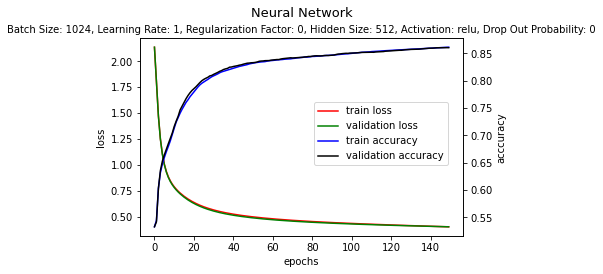

In [67]:
NN = NeuralNetwork(batch_size, lr, n_epochs, reg_factor, val_per, hidden_size, activation, drop_prob)
w1, w2, x_test_bias = NN.train()
NN.plot()
_ = NN.test(x_test_bias, w1, w2)